Notes from https://arxiv.org/pdf/2411.11269 [1]

https://arxiv.org/pdf/2411.11269 uses Variable Projection to determine the content of the model rather than least squares. They employ VARPO (https://github.com/sxs-collaboration/varpro) at late times to determine the complex amplitudes and frequencies of very long-lived modes (above the noise floor), then step backwards (fixing the frequencies of known modes at later times)

*Things to consider:

- Neglect contribution to null memory
- Adjust the scale of the time coordinate to match the convention in tabulated values 
- Adding a constant term to the superposition to account for an unknown cpt of the ringdown 

____

Higher overtone number amplitudes become unstable at earlier times, even in the presence of an extremely low noise floor. The effect cascades to lower overtone number in part due to the higher modes becoming unresolvable yet remaining in the model at these times. In other words, including modes in the fit that are no longer present in the data spoils the resolvability of the modes that are still present. To remedy this, we can remove modes at the time they become unresolvable (which in practise happens sequentially from $n=9$ backwards.)
___

In this notebook we don't (yet) account for the above considerations*, nor do we use VARPO. We take the given model determined in [1] and apply it, removing modes when their amplitudes become unstable. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qnmfits
import CCE
from likelihood_funcs import *
from GP_funcs import *
import corner
import scipy
import pickle
from qnm_selecting_funcs import *

In [2]:
id = "0001"
sim_main = CCE.SXS_CCE(id, lev="Lev5", radius="R2")

peak_time = 5
T = 50

chif_mag_0 = sim_main.chif_mag
Mf_0 = sim_main.Mf

In [3]:
n_max = 6

qnm_list = [(3, 2, 0, 1), (3, 2, 1, 1)] + [
    (2, 2, n, 1) for n in np.arange(0, n_max + 1)
]
# [(4,4,0,1,2,-2,0,-1), (4,4,0,1,3,-2,0,-1), (2,2,0,1,2,2,0,1), (2,2,0,1,2,0,0,-1)] +
spherical_mode = (2, 2)

### No mode dropping

In [4]:
start_times = np.linspace(7, 30, 100)
closest_peak_time = min(start_times, key=lambda x: abs(x - peak_time))

amplitude_array = np.zeros((len(start_times), len(qnm_list)), dtype=complex)
peak_amplitudes = []

for i, t0 in enumerate(start_times):

    ls_fit = qnmfits.ringdown_fit(
        sim_main.times,
        sim_main.h[spherical_mode],
        modes=qnm_list,
        Mf=Mf_0,
        chif=chif_mag_0,
        t0=t0,
        T=T,
    )

    if t0 == closest_peak_time:
        peak_amplitudes = ls_fit["C"]

    amplitude_array[i, :] = ls_fit["C"]

omega_list = ls_fit["frequencies"]

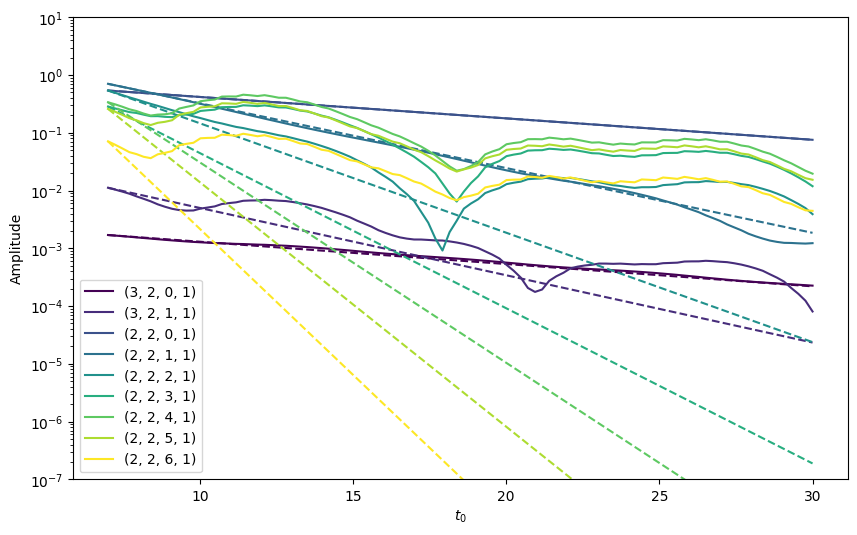

In [5]:
colours = plt.cm.viridis(np.linspace(0, 1, len(qnm_list)))

fig, ax = plt.subplots(figsize=(10, 6))

for i, qnm in enumerate(qnm_list):
    ax.plot(
        start_times, np.abs(amplitude_array[:, i]), label=f"{qnm}", color=colours[i]
    )
    ax.plot(
        start_times,
        np.abs(peak_amplitudes[i])
        * np.exp(-omega_list[i].imag * (closest_peak_time - start_times)),
        linestyle="--",
        color=colours[i],
    )
ax.set_yscale("log")
ax.set_ylim(1e-7, 1e1)
ax.set_xlabel(r"$t_0$")
ax.set_ylabel("Amplitude")
ax.legend()
plt.show()

### Mode dropping based on amplitude stability

In [6]:
start_times = np.linspace(7, 30, 100)

amplitude_array = np.zeros((len(start_times), len(qnm_list)), dtype=complex)
peak_amplitudes = []

ls_fit = qnmfits.ringdown_fit(
    sim_main.times,
    sim_main.h[spherical_mode],
    modes=qnm_list,
    Mf=Mf_0,
    chif=chif_mag_0,
    t0=peak_time,
    T=T,
)

peak_amplitudes = ls_fit["C"]
omega_list = ls_fit["frequencies"]

In [7]:
amplitude_array = np.zeros((len(start_times), len(qnm_list)), dtype=complex)

cutoff = []

qnm_list_new = qnm_list.copy()

for i, t0 in enumerate(start_times):

    ls_fit = qnmfits.ringdown_fit(
        sim_main.times,
        sim_main.h[spherical_mode],
        modes=qnm_list_new,
        Mf=Mf_0,
        chif=chif_mag_0,
        t0=t0,
        T=T,
    )

    amplitude_array[i, :] = ls_fit["C"]
    expected_amplitude = np.abs(peak_amplitudes[N]) * np.exp(
        -omega_list[N].imag * (closest_peak_time - t0)
    )

NameError: name 'N' is not defined

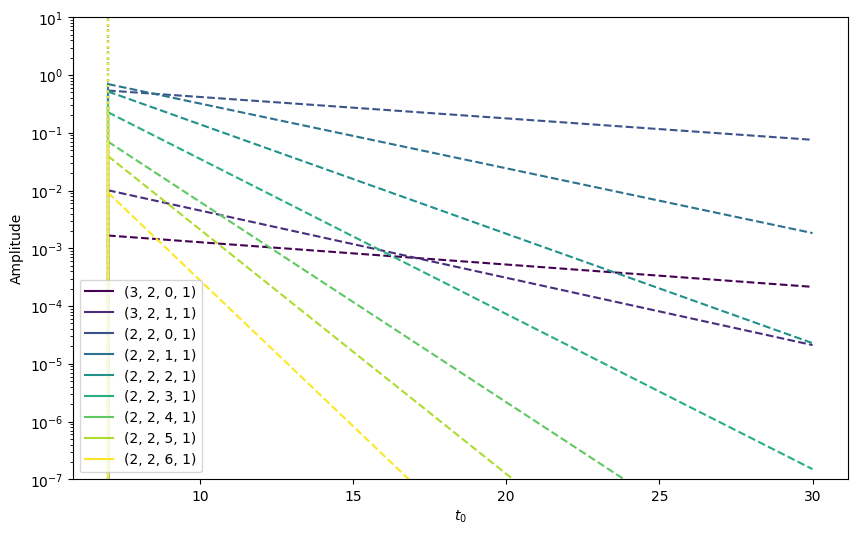

In [8]:
colours = plt.cm.viridis(np.linspace(0, 1, len(qnm_list)))

fig, ax = plt.subplots(figsize=(10, 6))

for i, qnm in enumerate(qnm_list):
    expected_amplitude = np.abs(peak_amplitudes[i]) * np.exp(
        -omega_list[i].imag * (peak_time - start_times)
    )
    ax.plot(
        start_times, np.abs(amplitude_array[:, i]), label=f"{qnm}", color=colours[i]
    )
    ax.plot(start_times, expected_amplitude, linestyle="--", color=colours[i])

    for j, t0 in enumerate(start_times):
        if (
            np.abs(amplitude_array[j, i] - expected_amplitude[j])
            / np.abs(expected_amplitude[j])
            > 1e0
        ):
            ax.axvline(t0, color=colours[i], linestyle=":")
            break

ax.set_yscale("log")
ax.set_ylim(1e-7, 1e1)
ax.set_xlabel(r"$t_0$")
ax.set_ylabel("Amplitude")
ax.legend()
plt.show()

## Mode dropping based on GP kernel + bayesian fits

In [9]:
analysis_mask = (sim_main.times >= t0 - 1e-9) & (sim_main.times < t0 + T)
analysis_times = sim_main.times[analysis_mask]

In [10]:
with open("param_dict_sim_lm_full.pkl", "rb") as f:
    param_dict_sim_lm = pickle.load(f)

with open("f_dict_sim_lm_full.pkl", "rb") as f:
    f_dict_sim_lm = pickle.load(f)

tuning_hyperparams = [
    1.321358102430008,
    -0.01345115218261082,
    4.093379916592142,
    0.5113668268176057,
]

hyperparam_rule_dict = {
    "sigma_max": "multiply",
    "t_s": "sum",
    "length_scale": "multiply",
    "period": "multiply",
}

In [ ]:
tuned_param_dict = get_tuned_params(
    param_dict_sim_lm[id],
    tuning_hyperparams,
    hyperparam_rule_dict,
    spherical_modes=[spherical_mode],
)
qnm_ordering = [(2, 2, n, 1) for n in np.arange(n_max, -1, -1)]

qnm_list_timeseries = []
qnm_list_new = qnm_list.copy()
data_times = sim_main.times
data = sim_main.h
spherical_modes = [spherical_mode]
threshold_sig = -5

[(2, 2, 6, 1), (2, 2, 5, 1), (2, 2, 4, 1), (2, 2, 3, 1), (2, 2, 2, 1), (2, 2, 1, 1), (2, 2, 0, 1)]


In [32]:
for t0 in start_times:
    print(f"t0 = {t0}")
    epsilon = 1e-9
    analysis_times = data_times[(data_times >= t0 - epsilon) & (data_times < t0 + T)]
    covariance = get_GP_covariance_matrix(analysis_times, kernel, tuned_param_dict)
    fisher_matrix = get_fisher_matrix(
        qnm_list_new, spherical_modes, t0, data_times, Mf_0, chif_mag_0, covariance, T=T
    )
    b_vec = get_b_vector(
        qnm_list_new,
        spherical_modes,
        t0,
        data_times,
        data,
        Mf_0,
        chif_mag_0,
        covariance,
        T=T,
    )

    fisher_matrix_init = fisher_matrix.copy()
    b_vec_init = b_vec.copy()
    param_list_init = [qnm for qnm in qnm_list_new for _ in range(2)]
    qnm_list_reduced = qnm_list_new.copy()

    for qnm_choice in qnm_ordering:
        mask = np.array([qnm in qnm_list_reduced for qnm in param_list_init])
        fisher_matrix_reduced = fisher_matrix_init[mask][:, mask]
        b_vec_reduced = b_vec_init[mask]
        mean_vector_reduced = np.linalg.solve(fisher_matrix_reduced, b_vec_reduced)
        param_list_reduced = [qnm for qnm in qnm_list_reduced for _ in range(2)]
        marginal_mean, marginal_fisher = marginalise(
            [qnm_choice], param_list_reduced, mean_vector_reduced, fisher_matrix_reduced
        )
        marginal_covariance = np.linalg.inv(marginal_fisher)
        try:
            significance = get_significance(marginal_mean, marginal_covariance)
        except np.linalg.LinAlgError:
            print("issue with qnm_choice")
        if significance < threshold_sig:
            qnm_list_reduced.remove(qnm_choice)
            qnm_ordering.remove(qnm_choice)
            print(
                f"{qnm_choice} in ordered list removed with significance {significance}"
            )
        else:
            break

    qnm_list_timeseries.append(qnm_list_new)

t0 = 7.0
Precomputation time:  0.0009794235229492188
Fisher matrix computation time:  0.12400197982788086
t0 = 7.232323232323233
Precomputation time:  0.0009205341339111328
Fisher matrix computation time:  0.12134265899658203
t0 = 7.4646464646464645
Precomputation time:  0.0009336471557617188
Fisher matrix computation time:  0.1244809627532959
t0 = 7.696969696969697
Precomputation time:  0.0009183883666992188
Fisher matrix computation time:  0.12097787857055664
t0 = 7.929292929292929
Precomputation time:  0.0009188652038574219
Fisher matrix computation time:  0.12227058410644531
issue with qnm_choice
t0 = 8.16161616161616
Precomputation time:  0.0009431838989257812
Fisher matrix computation time:  0.1195976734161377
t0 = 8.393939393939394
Precomputation time:  0.0009164810180664062
Fisher matrix computation time:  0.1217951774597168
t0 = 8.626262626262626
Precomputation time:  0.0009226799011230469
Fisher matrix computation time:  0.12332868576049805
t0 = 8.858585858585858
Precomputati